## Preprocessing pipeline for CNN approach

### INTRODUCTION

- most of the approaches focused either on feature extraction from the time series (can be found in the ts_features.ipynb) or some king of RNNs to handle raw sequences data. Here i try osme other idea and reshape input into the format usable for CNN.
- It suppouse to be a prof of concept and not maximum

_____

### SETUP

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import os
import gc
import itertools
import datetime
import glob
from collections import Counter
import bottleneck as bn
import pdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import optimizers
from tensorflow.python.keras import callbacks
from tensorflow.python.keras.models import *
from tensorflow.python.keras.layers import *

from multiprocessing import Pool
from numba import jit
import h5py
from astropy.table import Table

In [2]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 9318819588399065591),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 10472072263786599069),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 9430962879838792724),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 7931884340, 1932450278514262839)]

____

### HELPERS

In [31]:
def make_lcarr(object_id):
    '''Extracts and reshapes light curve values into (6, 72, 2) format: passbands x length, errors->channels'''
    lc = df[df['object_id'] == object_id].groupby(['passband']).apply(np.array).values
    lo = []
    for i in range(6):
        p1 = lc[i][:,[2,3]] # flux, err columns
        p2 = np.zeros(shape=(72, 2))
        p2[:p1.shape[0],:p1.shape[1]] = p1
        lo.append(p2)
    return np.asarray(lo)

In [32]:
def show_flux(array, ind=0):
    plt.ylabel("channel")
    plt.imshow(array[ind][0:6,0:72,0])

    
def show_imgs(array, n=30):
    plt.figure(figsize=(14, 6))
    for i in range(n):
        plt.gray()
        ax = plt.subplot(n/3, 3, i+1)
        show_flux(array, ind=i)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def plot_training(history):
    print(f"Max val accuracy: {np.max(history.history['val_main_output_acc'])}")
    print(f"Min val loss: {np.min(history.history['val_main_output_loss'])}")
    #print(history.history.keys())
    
    # summarize history for accuracy
    #plt.subplot(1, 2, 1)
    plt.plot(history.history['main_output_acc'])
    plt.plot(history.history['val_main_output_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    # plt.subplot(1, 2, 2)
    plt.plot(history.history['main_output_loss'])
    plt.plot(history.history['val_main_output_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

____

### LOAD TRAINNING DATA

In [33]:
tr = pd.read_csv("../input/training_set.csv")
tr_meta = pd.read_csv("../input/training_set_metadata.csv")
sample_sub = pd.read_csv("../input/sample_submission.csv")

### PREP TARGETS

In [34]:
y = tr_meta['target']
classes = sorted(y.unique())
class_names = list(sample_sub.columns[1:-1])

print(f'Unique classes : {classes}')
print(f'Classes names: {class_names}')

Unique classes : [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
Classes names: ['class_6', 'class_15', 'class_16', 'class_42', 'class_52', 'class_53', 'class_62', 'class_64', 'class_65', 'class_67', 'class_88', 'class_90', 'class_92', 'class_95']


In [35]:
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])
y_train = to_categorical(y_map)

In [36]:
class_map

{6: 0,
 15: 1,
 16: 2,
 42: 3,
 52: 4,
 53: 5,
 62: 6,
 64: 7,
 65: 8,
 67: 9,
 88: 10,
 90: 11,
 92: 12,
 95: 13}

In [37]:
y_train[0:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]],
      dtype=float32)

** Classes weights**

In [38]:
class_weight = {c: 1 for c in classes}
for c in [64, 15]:
    class_weight[c] = 2

In [39]:
print(f'Class weights: {class_weight}')

Class weights: {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}


In [40]:
y_count = Counter(y_map)
wtable = np.zeros((len(unique_y),))
for i in range(len(unique_y)):
    wtable[i] = y_count[i]/y_map.shape[0]

### MAKE FLUX AND ERROR INPUTS

In [41]:
# making grouped normalization faster with broadcasting:
# https://stackoverflow.com/questions/26046208/normalize-dataframe-by-group
def normalize_by_group(df, by):
    groups = df.groupby(by)
    mean = groups.transform(np.mean)
    std = groups.transform(np.std)
    return (df[mean.columns] - mean) / std

In [42]:
%%time
# normalize flux and flux_err by star (loosing overall flux level)
df = tr[['object_id', 'passband', 'flux', 'flux_err']]
df.loc[:,['flux', 'flux_err']] = normalize_by_group(df, ['object_id', 'passband'])
df.fillna(0, inplace=True)

# multiprocess make array
objects_list = df['object_id'].unique().tolist()
pool = Pool(8)
result = pool.map(make_lcarr, objects_list)
pool.close()
x_train = np.stack(result)

print(x_train.shape)

/home/paperspace/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/paperspace/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


(7848, 6, 72, 2)
CPU times: user 2.7 s, sys: 2.09 s, total: 4.79 s
Wall time: 6.8 s


**Photometry data reshaped into 2D image-like format:**

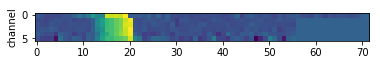

In [43]:
show_flux(x_train, 123)

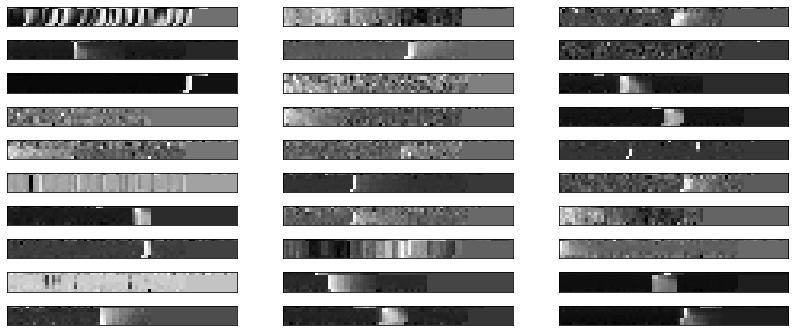

In [44]:
show_imgs(x_train, 30)

In [45]:
print("x_train shape:{}".format(x_train.shape), "y_train shape:{}".format(y_train.shape))

x_train shape:(7848, 6, 72, 2) y_train shape:(7848, 14)


- visible edges corresponding to rapid as well as gradients with different intensities for different channels
- since sequences have different lengths, I pad them and fill missing data with zeros (since data are scaled and centered, 0 correspond to the mean of registered data for a given star)
- aligning is problematic and CNN can help with that if missalignments between channels are non random (based on the description provided by organizers they are not)

____

### MAKE META DATA INPUTS

In [51]:
tr_meta.head()

object_id          ra       decl       gal_l      gal_b  ddf  \
0        615  349.046051 -61.943836  320.796530 -51.753706    1   
1        713   53.085938 -27.784405  223.525509 -54.460748    1   
2        730   33.574219  -6.579593  170.455585 -61.548219    1   
3        745    0.189873 -45.586655  328.254458 -68.969298    1   
4       1124  352.711273 -63.823658  316.922299 -51.059403    1   

   hostgal_specz  hostgal_photoz  hostgal_photoz_err  distmod  mwebv  target  
0         0.0000          0.0000              0.0000      NaN  0.017      92  
1         1.8181          1.6267              0.2552  45.4063  0.007      88  
2         0.2320          0.2262              0.0157  40.2561  0.021      42  
3         0.3037          0.2813              1.1523  40.7951  0.007      90  
4         0.1934          0.2415              0.0176  40.4166  0.024      90

In [52]:
scaler = StandardScaler()
x_meta = tr_meta.drop(['object_id', 'target', 'distmod', 'hostgal_photoz'], axis=1)
x_meta.fillna(0, inplace=True)
x_meta[list(x_meta.columns)] = scaler.fit_transform(x_meta[list(x_meta.columns)])
x_meta = np.array(x_meta)
x_meta.shape

(7848, 8)

In [53]:
# apply for the test!
print(scaler.mean_); print(scaler.var_)

[ 1.69719379e+02 -2.72548463e+01  2.30466784e+02 -2.01155259e+01
  2.69622834e-01  2.54436430e-01  1.55694699e-01  8.19525994e-02]
[1.30428927e+04 4.09951785e+02 9.48874420e+03 1.63121681e+03
 1.96926361e-01 1.08921004e-01 9.02090530e-02 2.26767725e-02]


____

### MODEL

Custom loss function with classes weights used in the competition:

In [75]:
def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

In [76]:
myadam = optimizers.adam(lr=0.01)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0005)

In [77]:
flux_input = Input(shape=(6, 72, 2), name='main_input')
x = Conv2D(250, kernel_size=(3, 3), activation='relu', name='conv1')(flux_input)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = GlobalAvgPool2D()(x) #!!!
x = Dense(150, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
auxiliary_output = Dense(len(classes), activation='softmax', name='aux_output')(x)
meta_input = Input(shape=(8,), name='meta_input')
x = concatenate([x, meta_input])
x = Dense(150, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
main_output = Dense(len(classes), activation='softmax', name='main_output')(x)

model = Model(inputs=[flux_input, meta_input], outputs=[main_output, auxiliary_output])
model.compile(optimizer='adam', loss=mywloss, metrics=['accuracy'])
#model.summary()

____

### TRAINING

In [78]:
%%time
history = model.fit([x_train, x_meta], [y_train, y_train],
                    validation_split=0.2, 
                    epochs=300,
                    batch_size=128,
                    shuffle=True,
                    verbose=False) 

CPU times: user 4min 8s, sys: 1min 2s, total: 5min 10s
Wall time: 4min 24s


Max val accuracy: 0.6254777074619463
Min val loss: 0.8457254010400954


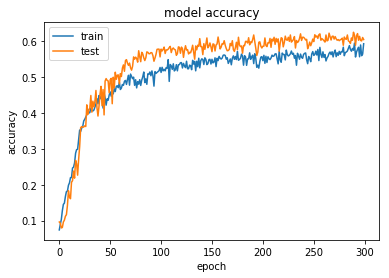

In [79]:
plot_training(history)

In [80]:
model_name = "fun_cnn_72days_err_2_300"
model.save(f'../models/{model_name}.h5')

-----

### PREP TEST FLUX

In [11]:
!wc -l ../input/test_set.csv && stat --printf="%s" ../input/test_set.csv

453653105 ../input/test_set.csv
19793878383

Since the test set is quite big it won't fit into my memory. Let's use Dask and iteratively preprocess raw csv.

In [5]:
gc.collect()

11

In [6]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [56]:
%%time
import dask.dataframe as dd
df_test = dd.read_csv('../input/test_set.csv')
test_objects_list = df_test['object_id'].unique().compute().tolist()
print(len(test_objects_list))

3492890
CPU times: user 6min 42s, sys: 4min 6s, total: 10min 48s
Wall time: 1min 26s


In [ ]:
%%time
objects_chunks = chunks(test_objects_list, 100000) #35
for idx, chunk in enumerate(objects_chunks):
    df = df_test[df_test.object_id.isin(chunk)].compute()[['object_id', 'passband', 'flux', 'flux_err']]
    df.loc[:,['flux', 'flux_err']] = normalize_by_group(df, ['object_id', 'passband'])
    df.fillna(0, inplace=True)

    # multiprocess make array
    pool = Pool(8)
    result = pool.map(make_lcarr, chunk)
    pool.close()
    batch_results = np.stack(result)
    np.save(f'../data/x_test_{idx}.npy', batch_results)
    gc.collect()

**merge chunks**

In [162]:
%%time
chunk_files = glob.glob("../data/*.npy")
chunk_files.sort(key=os.path.getmtime)
x_test = np.empty(shape=(0, 6, 72, 2))
np.save('../data/x_test.npy', x_test)

with open('../data/x_test.npy', 'ba+') as f:
    for chunk_file in chunk_files:
        test_chunk = np.load(chunk_file)
        test_chunk.tofile(f)
        #np.save(f, test_chunk)

CPU times: user 1.07 s, sys: 40.1 s, total: 41.2 s
Wall time: 1min 47s


In [ ]:
header = {'descr': fmt.dtype_to_descr(np.dtype('float64')), 'fortran_order': False, 'shape': (3492890, 6, 72, 2)}
with open('../data/x_test.npy', 'wb') as f:
        fmt.write_array_header_2_0(f, header)

_____

### PREP TEST METADATA

In [57]:
test_meta = pd.read_csv("../input/test_set_metadata.csv")

# make sure flux and meta order is the same
test_meta = test_meta.set_index('object_id')
test_meta = test_meta.loc[test_objects_list]
test_meta.reset_index(inplace=True)
meta_objects_list = test_meta['object_id'].unique().tolist()
assert(meta_objects_list == test_objects_list)

In [58]:
test_meta.head()

object_id          ra       decl       gal_l      gal_b  ddf  \
0         13   34.453125  -5.229529  169.987075 -59.956185    1   
1         14   33.398438  -4.331149  167.226341 -59.936551    1   
2         17  348.529419 -61.755440  321.293980 -51.763351    1   
3         23   34.804688  -5.829153  171.307861 -60.174401    1   
4         34  351.321442 -64.198746  317.458993 -50.429931    1   

   hostgal_specz  hostgal_photoz  hostgal_photoz_err  distmod  mwebv  
0         0.3048          0.3193              0.0542  41.1123  0.019  
1            NaN          0.6323              0.0179  42.8774  0.018  
2            NaN          0.8297              0.0605  43.6000  0.016  
3            NaN          0.6533              0.1479  42.9640  0.023  
4         0.4557          0.4617              0.0122  42.0540  0.023

In [59]:
%%time
x_meta_test = test_meta.drop(['object_id', 'distmod', 'hostgal_photoz'], axis=1)
x_meta_test.fillna(0, inplace=True)
x_meta_test[list(x_meta_test.columns)] = scaler.transform(x_meta_test[list(x_meta_test.columns)])
x_meta_test = np.array(x_meta_test)
x_meta_test.shape

CPU times: user 9.33 s, sys: 10.6 s, total: 19.9 s
Wall time: 4.69 s


In [61]:
np.save("../input/x_test_meta.npy", x_meta_test)

-----

### PREDICTIONS

Iterativele predict test chunks:

In [ ]:
# make sure flux and meta order is the same
test_meta = test_meta.set_index('object_id')
test_meta = test_meta.loc[test_objects_list]
test_meta.reset_index(inplace=True)
meta_objects_list = test_meta['object_id'].unique().tolist()
assert(meta_objects_list == test_objects_list)

In [ ]:
class_names_sub = sample_sub.columns[1:]

In [163]:
x_test_dir = "../input/x_test.npy"
x_test_meta_dir = "../input/x_test_meta.npy"

In [175]:
%%time
preds = model.predict([np.load(x_test_dir, mmap_mode='r+'), np.load(x_test_meta_dir, mmap_mode='r')])[0]
preds_c = (preds == preds.max(axis=1)[:,None]).astype(int)

CPU times: user 4min 2s, sys: 1min 22s, total: 5min 24s
Wall time: 3min 18s


In [200]:
submission = sample_sub
submission = submission.set_index('object_id')
submission = submission.loc[test_objects_list]
submission.reset_index(inplace=True)
submission.loc[:,1:15] = preds_c
submission.to_csv('../output/sub1.gz', index=False, compression='gzip')